In [1]:
import os
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.optimize import curve_fit 
import math

# imports of our code 
from load_models import *
import LocalLearning_copy as LocalLearning

In [2]:
torch.manual_seed(7)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

# loss function
ce_loss = torch.nn.CrossEntropyLoss()

In [4]:
cifar10Train= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=True,
            transform=ToTensor(),
            p=3.0,
        )

cifar10Test= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=False,
            transform=ToTensor(),
            p=3.0,
        )

TestLoader = LocalLearning.DeviceDataLoader(
            cifar10Test,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

TrainLoader = LocalLearning.DeviceDataLoader(
            cifar10Train,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

Files already downloaded and verified
Files already downloaded and verified


In [27]:
def show_image(features):
    
    def MinMaxNorm(x: np.array) -> np.array:
        mi = np.amin(x)
        ma = np.amax(x)
        return (x - mi) / (ma - mi)

    f_np = features.detach().cpu().numpy()
    HM = np.zeros((32, 32, 3))
    HM = np.transpose(f_np[42], (0, 1, 2))
    HM = MinMaxNorm(HM)
    nc = np.max(np.absolute(HM))
    fig, ax = plt.subplots()
    ax.imshow(HM, vmin=-nc, vmax=+nc)

In [6]:
def data_critirium(
    dataloader,
    model, 
    crit,
    thres = None
    ):
    
    # Returns the data and the corresponding labels that meets the critirium given (crit)
    
    freq_correct = 0
    model.eval()
    total = 0
    
    data = torch.zeros((0,32,32,3)).to(device)
    lab_data = torch.zeros((0)).to(device)
    
    for batch_no, (features, labels) in enumerate(dataloader):
        preds = model(features)
        pred = torch.argmax(preds, dim=-1)
        
        if crit == "correct":
            filtr_idx = (torch.abs(pred - labels) == 0)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
        
        elif crit == "correct_thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            thres_idx = (softmax_correct >= thres)
            correct_idx = (torch.abs(pred - labels) == 0)
            filtr_idx = thres_idx & correct_idx 
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
            
        elif crit == "thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            filtr_idx = (softmax_correct >= thres)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
            
        else: 
            raise ValueError("Not a valid criterium")
    
    return data, lab_data

In [7]:
max_num_steps = 1200
step_size = 0.001
n = 0
eps_start = 0.001

eps_list = [eps_start + n * step_size for n in range(max_num_steps + 1)]

In [8]:
def crit_eps_fgsm(criterium, model, print_accuracy):
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device).fill_(math.nan)   
    crit_dist_per_image = torch.ones(siz).to(device).fill_(math.nan)
    
    freq_correct = 0
    total = 0 

    loss_fn = ce_loss 
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    correct = []

    #while n < max_num_steps and torch.sum(crit_eps_per_image.isnan()).item() > 0:
    for eps in eps_list:
        preds = model(features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            
            perturbed_image = features + eps*features.grad.data.sign()
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
            preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
            alike = (preds_perturbed == labels)
            freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
            total += len(labels)

            correct.append((freq_correct/total).item())

            mask = (alike == False) & (crit_eps_per_image.isnan())

            x = features.view(features.size(0), -1)
            y = perturbed_image.view(perturbed_image.size(0), -1)

            dist = torch.norm(x - y, dim=1).detach()

            crit_dist_per_image[mask] = dist[mask]
            
            perturbation = torch.abs(features - perturbed_image).detach()
            avg_perturbation = torch.sum(perturbation.view(perturbation.size(0), -1), dim=1) / (perturbation.size(1) * perturbation.size(2) * perturbation.size(3))
            crit_eps_per_image[mask] = avg_perturbation[mask]            
            
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% is still correctly classified")
        print(f"{100*(torch.sum(crit_eps_per_image.isnan()).item())/siz}% have been correctly classified at every step")
        
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
    crit_dist_per_image = np.array(crit_dist_per_image.cpu())
    correct = np.array(correct)
        
    return crit_eps_per_image, crit_dist_per_image, correct 


In [19]:
def crit_eps_pgd(criterium, model, print_accuracy):
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device).fill_(math.nan)   
    crit_dist_per_image = torch.ones(siz).to(device).fill_(math.nan)

    freq_correct = 0
    total = 0 

    loss_fn = ce_loss 
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    correct = []

    perturbed_image = features 
    b_norm = 0.05

    #while n < max_num_steps and torch.sum(crit_eps_per_image.isnan()).item() > 0:
    for eps in eps_list:
        preds = model(features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            adv_image = perturbed_image + step_size*features.grad.data.sign()
            clamp = torch.clamp(adv_image - features, min = -b_norm, max = b_norm)
            perturbed_image = torch.clamp(features + clamp, min = 0, max = 1)
        
            preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
            alike = (preds_perturbed == labels)
            freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
            total += len(labels)

            correct.append((freq_correct/total).item())

            mask = (alike == False) & (crit_eps_per_image.isnan())

            x = features.view(features.size(0),-1)
            y = perturbed_image.view(perturbed_image.size(0),-1)

            dist = torch.norm(x - y, dim=1).detach()

            crit_dist_per_image[mask] = dist[mask]
            
            perturbation = torch.abs(features - perturbed_image).detach()
            avg_perturbation = torch.sum(perturbation.view(perturbation.size(0), -1), dim=1) / (perturbation.size(1) * perturbation.size(2) * perturbation.size(3))
            crit_eps_per_image[mask] = avg_perturbation[mask]
    
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% is still correctly classified")
        print(f"{100*(torch.sum(crit_eps_per_image.isnan()).item())/siz}% have been correctly classified at every step")
        
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
    crit_dist_per_image = np.array(crit_dist_per_image.cpu())
    correct = np.array(correct)
        
    return crit_eps_per_image, crit_dist_per_image, correct 


In [20]:
def crit_eps_wn(criterium, model, print_accuracy):
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device).fill_(math.nan)   
    crit_dist_per_image = torch.ones(siz).to(device).fill_(math.nan)   

    freq_correct = 0
    total = 0 

    labels = labels.type(torch.LongTensor).to(device)

    correct = []
    
    noise = torch.randn(features.shape).to(device)
    
    #while n < max_num_steps and torch.sum(crit_eps_per_image.isnan()).item() > 0:
    for eps in eps_list:

        adv_image = features + eps*noise
        perturbed_image = torch.clamp(adv_image, min = 0, max = 1)

        preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
        alike = (preds_perturbed == labels)
        freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
        total += len(labels)

        correct.append((freq_correct/total).item())

        mask = (alike == False) & (crit_eps_per_image.isnan())

        x = features.view(features.size(0),-1)
        y = perturbed_image.view(perturbed_image.size(0),-1)

        dist = torch.norm(x - y, dim=1).detach()
        
        crit_dist_per_image[mask] = dist[mask]
        
        perturbation = torch.abs(features - perturbed_image).detach()
        avg_perturbation = torch.sum(perturbation.view(perturbation.size(0), -1), dim=1) / (perturbation.size(1) * perturbation.size(2) * perturbation.size(3))
        crit_eps_per_image[mask] = avg_perturbation[mask]
        
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% is still correctly classified")
        print(f"{100*(torch.sum(crit_eps_per_image.isnan()).item())/siz}% have been correctly classified at every step")
        
    crit_dist_per_image = np.array(crit_dist_per_image.cpu())
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
    correct = np.array(correct)

    return crit_eps_per_image, crit_dist_per_image, correct 

In [30]:
def crit_eps(criterium, model, attack, print_accuracy):
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device).fill_(math.nan)   
    crit_dist_per_image = torch.ones(siz).to(device).fill_(math.nan)

    freq_correct = 0
    total = 0 

    loss_fn = ce_loss 
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    correct = []

    perturbed_image = features 
    b_norm = 0.05
    
    noise = torch.randn(features.shape).to(device)

    for eps in eps_list:
        
        preds = model(features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        
        with torch.no_grad():
        
            if attack == "WN":
                adv_image = features + eps*noise
                perturbed_image = torch.clamp(adv_image, min = 0, max = 1)

            elif attack == "PGD":

                adv_image = perturbed_image + step_size*features.grad.data.sign()
                clamp = torch.clamp(adv_image - features, min = -b_norm, max = b_norm)
                perturbed_image = torch.clamp(features + clamp, min = 0, max = 1)
                
            elif attack == "FGSM":
                
                perturbed_image = features + eps*features.grad.data.sign()
                perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
            preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
            alike = (preds_perturbed == labels)
            freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
            total += len(labels)

            correct.append((freq_correct/total).item())

            mask = (alike == False) & (crit_eps_per_image.isnan())

            x = features.view(features.size(0),-1)
            y = perturbed_image.view(perturbed_image.size(0),-1)

            dist = torch.norm(x - y, dim=1).detach()

            crit_dist_per_image[mask] = dist[mask]
            
            perturbation = torch.abs(features - perturbed_image).detach()
            avg_perturbation = torch.sum(perturbation.view(perturbation.size(0), -1), dim=1) / (perturbation.size(1) * perturbation.size(2) * perturbation.size(3))
            crit_eps_per_image[mask] = avg_perturbation[mask]
    
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% is still correctly classified")
        print(f"{100*(torch.sum(crit_eps_per_image.isnan()).item())/siz}% have been correctly classified at every step")
        
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
    crit_dist_per_image = np.array(crit_dist_per_image.cpu())
    correct = np.array(correct)
        
    return crit_eps_per_image, crit_dist_per_image, correct 


In [11]:
def critical_epsilon(criterium, model, attack, print_accuracy = False):
    
    if attack == "PGD":
        crit_eps = crit_eps_pgd(criterium, model, print_accuracy)
        
    elif attack == "FGSM":
        crit_eps = crit_eps_fgsm(criterium, model, print_accuracy)
    
    elif attack == "WN":
        crit_eps = crit_eps_wn(criterium, model, print_accuracy)
    
    else: 
        raise ValueError("Not a valid attack")
        
    return crit_eps

In [12]:
def boxplot(ll_crit_eps, bp_crit_eps, attack, typ):
    # Remove NaN values from the input data
    ll_crit_eps = ll_crit_eps[~np.isnan(ll_crit_eps)]
    bp_crit_eps = bp_crit_eps[~np.isnan(bp_crit_eps)]
    
    # Create the boxplot
    fig, ax = plt.subplots()
    ax.boxplot((ll_crit_eps, bp_crit_eps), showfliers=False)

    # Set the axis labels and title
    ax.set_xticklabels(['LL', 'BP'])
    if typ == "eps":
        ax.set_ylabel('Critical epsilon')
    elif typ == "dist":
        ax.set_ylabel('Critical distance')
        
    ax.set_title(f'Konstantin model {attack} attack')
    
    median_ll = np.nanmedian(ll_crit_eps)
    median_bp = np.nanmedian(bp_crit_eps)
    ax.text(0.95, 0.95, f"Median LL: {median_ll:.5f}\nMedian BP: {median_bp:.5f}", 
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=12)

    plt.show()


In [13]:
def plot_accuracy(ll, bp):
    plt.plot(ll*100,label="ll")
    plt.plot(bp*100,label="bp")
    plt.ylabel("Accuracy [%]")
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

In [14]:
# functions for downloading models in load_models.py 
bp_modelK = load_Konstantin_model("bp_KHModel_kh_layer_cifar10.pty","bp")
ll_modelK = load_Konstantin_model("ll_KHModel_kh_layer_cifar10.pty","ll")

In [15]:
print_accuracy = False

In [21]:
criteps_bp_wn, critdist_bp_wn, correct_bp_wn = crit_eps("correct", bp_modelK, "WN", print_accuracy=print_accuracy)
criteps_ll_wn, critdist_ll_wn, correct_ll_wn = crit_eps("correct", ll_modelK, "WN", print_accuracy=print_accuracy)

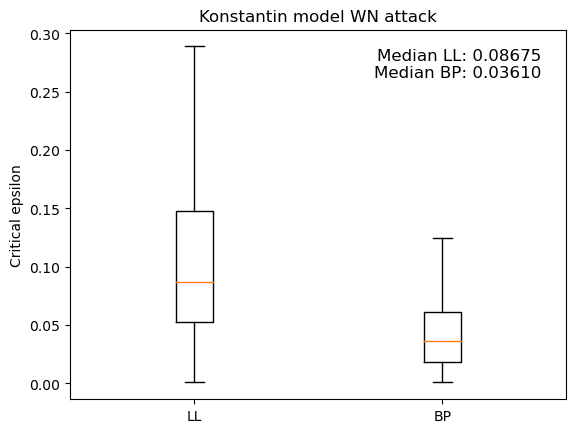

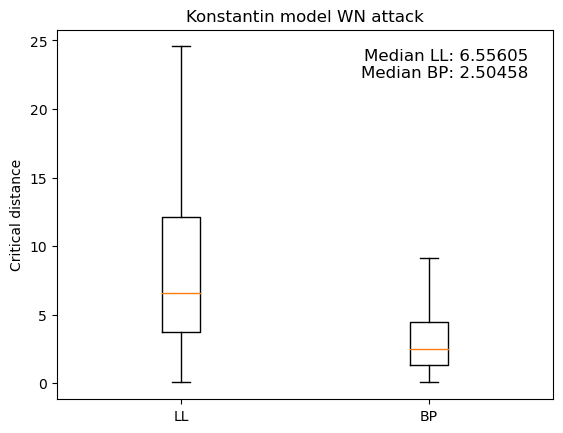

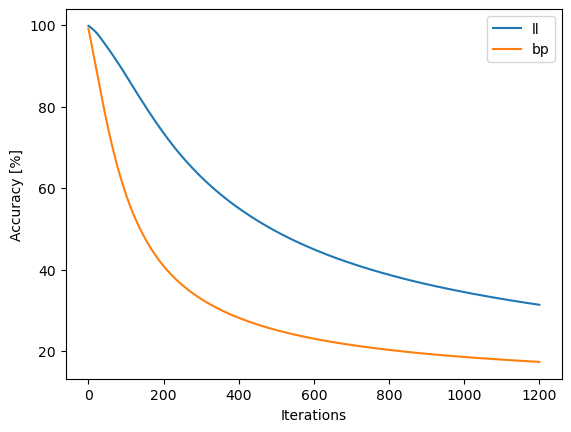

In [32]:
boxplot(criteps_ll_wn, criteps_bp_wn, "WN", "eps")
boxplot(critdist_ll_wn, critdist_bp_wn, "WN", "dist")
plot_accuracy(correct_ll_wn,correct_bp_wn)

In [33]:
criteps_bp_pgd, critdist_bp_pgd, correct_bp_pgd = crit_eps("correct", bp_modelK, "PGD", print_accuracy=print_accuracy)
criteps_ll_pgd, critdist_ll_pgd, correct_ll_pgd = crit_eps("correct", ll_modelK, "PGD", print_accuracy=print_accuracy)

KeyboardInterrupt: 

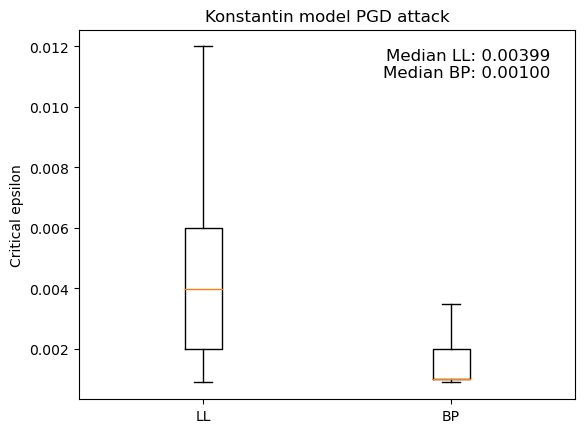

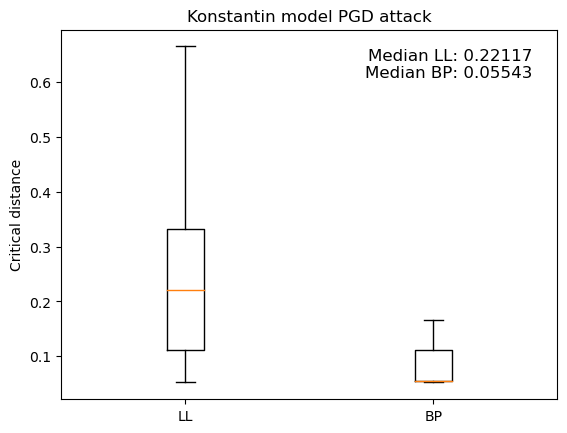

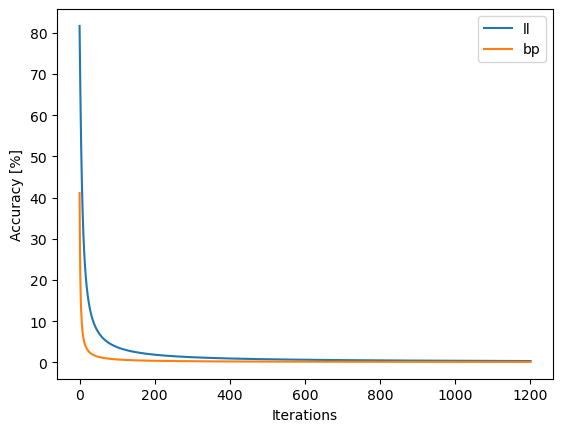

In [24]:
boxplot(criteps_ll_pgd, criteps_bp_pgd, "PGD", "eps")
boxplot(critdist_ll_pgd, critdist_bp_pgd, "PGD", "dist")
plot_accuracy(correct_ll_pgd,correct_bp_pgd)

In [25]:
criteps_bp_fgsm, critdist_bp_fgsm, correct_bp_fgsm = crit_eps("correct", bp_modelK, "FGSM", print_accuracy=print_accuracy)
criteps_ll_fgsm, critdist_ll_fgsm, correct_ll_fgsm = crit_eps("correct", ll_modelK, "FGSM", print_accuracy=print_accuracy)

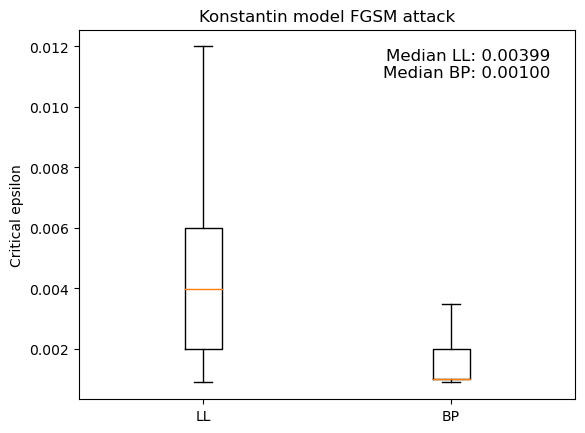

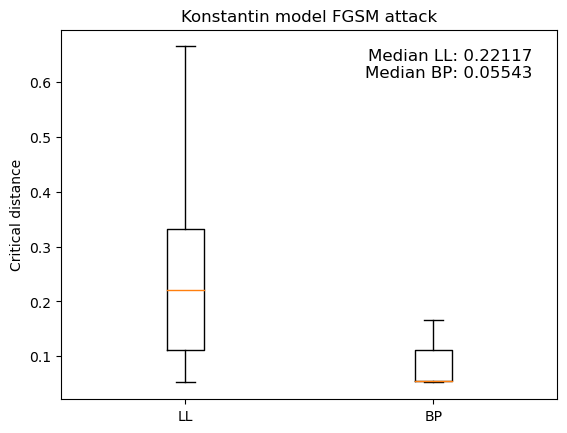

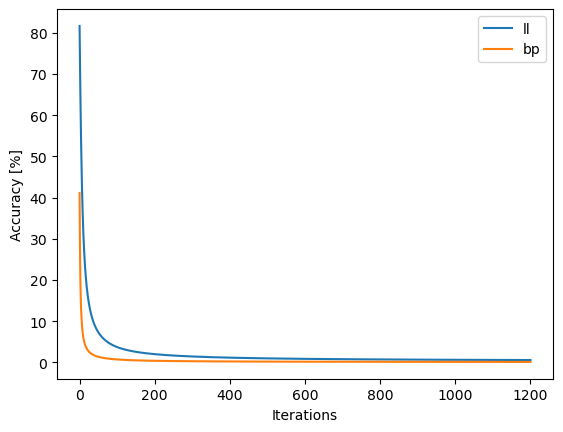

In [26]:
boxplot(criteps_ll_fgsm, criteps_bp_fgsm, "FGSM", "eps")
boxplot(critdist_ll_fgsm, critdist_bp_fgsm, "FGSM", "dist")
plot_accuracy(correct_ll_fgsm,correct_bp_fgsm)